## Importing the relevant packages


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA

from tools.metrics_generator import MetricsGenerator
from tools.model_generator import ModelGenerator

sns.set_theme(context="notebook", style="white")

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq("b")
df_comp = df_comp.ffill()

In [3]:
df_comp["market_value"] = df_comp.ftse

In [4]:
del df_comp["spx"]
del df_comp["dax"]
del df_comp["ftse"]
del df_comp["nikkei"]
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

## Stationarity ADF Test

In [5]:
sts.adfuller(df["market_value"])

(np.float64(-1.9041551418836848),
 np.float64(0.33010893277028397),
 6,
 5014,
 {'1%': np.float64(-3.4316548765428174),
  '5%': np.float64(-2.8621166146845334),
  '10%': np.float64(-2.5670769326348926)},
 np.float64(54854.15304507557))

- The t-statistic (-1.90) is higher than the 5% critical value.
- The p-value is higher than 0.05.
- The null hypothesis can not be rejected and the time series is **non-stationary**.

## Using Returns

- Because price data is non-stationary, an AR model is not suitable.
- However, it can be transformed into returns so that it fits the assumptions of stationarity. 

In [6]:
# Calculate simple returns and convert to a percentage
df["returns"] = df["market_value"].pct_change(periods=1).mul(100)

# Remove the first row as returns cannot be calculated for the first row
df = df[1:]
df

,market_value,returns
date,,
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
1994-01-14,3400.56,1.206842
...,...,...
2013-04-01,6411.74,0.000000
2013-04-02,6490.66,1.230867
2013-04-03,6420.28,-1.084327


Perform an ADF on the returns.

In [7]:
sts.adfuller(df["returns"])

(np.float64(-12.770265719497264),
 np.float64(7.798058336037375e-24),
 32,
 4987,
 {'1%': np.float64(-3.431661944885779),
  '5%': np.float64(-2.8621197374408225),
  '10%': np.float64(-2.5670785949998973)},
 np.float64(15696.767245697501))

- The t-statistic (-12.77) is more negative than the 5% critical value.
- The computed p-value is lower than 0.05.
- Both are significant. The null hypothesis can therefore be rejected, indicating that the data is meets the assumptions of stationarity.

## ACF and PACF for Returns

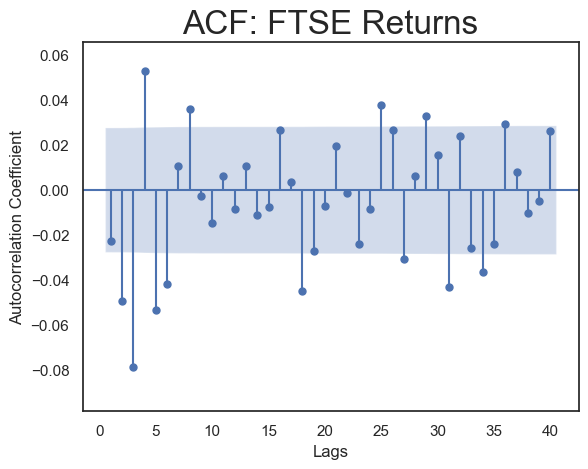

In [8]:
sgt.plot_acf(df["returns"], zero=False, lags=40, auto_ylims=True)
plt.title("ACF: FTSE Returns", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

- The ACF graph is very different from that for prices.
- The coefficients vary in sign, magnitude and significance.
- The first few lags are predomnantly significant and predominantly negative. This indicates that consecutive returns move in different directions.
- This suggests that returns oevr the entire week are relevant to the current one. (NB A business weekis 5 days.)
- The negative relationship can be interpreted as some form of natural adjustment occuring in the market.

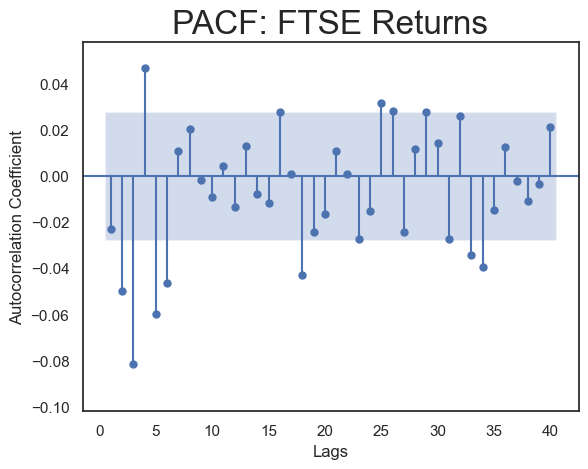

In [9]:
sgt.plot_pacf(
    df["returns"], alpha=0.05, zero=False, lags=40, method="ols", auto_ylims=True
)
plt.title("PACF: FTSE Returns", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

- The results are very similar to those for the ACF.
- Again, this indicates opposing price movements on a daily basis, which fits in with the expectation of cyclical changes.
- As the lags increase, the less relevant the coefficient values become. This is because the majority of effects that they have on current vaues should already have been accounted for due to the recursive nature of autoregressive models.
- 5 of the first 6 lags are negative. This indicates **clustering**, i.e. temporal structure exists.
  - There is mean-reverting behavior: A high value tends to be followed by a lower value, and vice versa.
  - The effect persists across multiple lags, which might suggest **volatility clustering** (a common pattern in financial time series).

## AR(1) for Returns

In [10]:
model_returns = ARIMA(df["returns"], order=(1, 0, 0))
result_returns = model_returns.fit()
result_returns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Sun, 01 Feb 2026   AIC                          15865.497
Time:                        11:54:22   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7872.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The p-value for $C$ is more than 0.05 and the critical values for this contain 0 within the range. Therefore, it is not significant.
- The p-value for the L1 coefficient is less than 0.05 and the critical value range does not cross 0. Therefore, the L1 coefficient is significant.

## Higher-Lag AR Models for Returns

In [11]:
model_generator_returns = ModelGenerator(data=df["returns"])
max_lags = 9
param_grid = [{"order": (p, 0, 0)} for p in range(1, max_lags + 1)]
model_generator_returns.generate_models(
    model_function=ARIMA, model_name_prefix="AR", param_grid=param_grid
)

model_generator_returns.summarise_results()

AR_1_0_0:
                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Sun, 01 Feb 2026   AIC                          15865.497
Time:                        11:54:34   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.09

#### Create a dataframe to tabulate measures of interest

In [12]:
metrics_returns = MetricsGenerator(models=model_generator_returns.models)
metrics_returns.generate_metrics_table()
metrics_returns.evaluation

,ar,ma,llf,aic,bic,hqic,final_lag,final_lag_pval,llr_test_models,llr_test_pval
model,,,,,,,,,,
AR_1_0_0,1,0,-7929.748722,15865.497445,15885.061000,15872.352777,ar.L1,0.00700,NaN,NaN
AR_2_0_0,2,0,-7923.455711,15854.911423,15880.996163,15864.051866,ar.L2,0.00000,AR_2_0_0 vs AR_1_0_0,3.886424e-04
AR_3_0_0,3,0,-7906.738406,15823.476811,15856.082737,15834.902366,ar.L3,0.00000,AR_3_0_0 vs AR_2_0_0,7.370062e-09
AR_4_0_0,4,0,-7901.330338,15814.660676,15853.787787,15828.371341,ar.L4,0.00000,AR_4_0_0 vs AR_3_0_0,1.006193e-03
AR_5_0_0,5,0,-7892.389707,15798.779415,15844.427711,15814.775191,ar.L5,0.00000,AR_5_0_0 vs AR_4_0_0,2.351249e-05
AR_6_0_0,6,0,-7886.944801,15789.889602,15842.059083,15808.170489,ar.L6,0.00000,AR_6_0_0 vs AR_5_0_0,9.669457e-04
AR_7_0_0,7,0,-7886.647041,15791.294081,15849.984748,15811.860079,ar.L7,0.22804,AR_7_0_0 vs AR_6_0_0,4.402923e-01
AR_8_0_0,8,0,-7885.599313,15791.198627,15856.410479,15814.049735,ar.L8,0.03133,AR_8_0_0 vs AR_7_0_0,1.477378e-01
AR_9_0_0,9,0,-7885.588878,15793.177757,15864.910794,15818.313976,ar.L9,0.81716,AR_9_0_0 vs AR_8_0_0,8.851339e-01


- The llf gradually becomes less negative, with slowing down AR_6 onwards.
- The AIC, BIC and HQIC decrease till AR_6 and then start to increase.

In [13]:
# Find models where both the final lag and the LLR Test p-values fail to reach significance.
metrics_returns.evaluation.query("final_lag_pval >= 0.05 and llr_test_pval >= 0.05")

,ar,ma,llf,aic,bic,hqic,final_lag,final_lag_pval,llr_test_models,llr_test_pval
model,,,,,,,,,,
AR_7_0_0,7,0,-7886.647041,15791.294081,15849.984748,15811.860079,ar.L7,0.22804,AR_7_0_0 vs AR_6_0_0,0.440292
AR_9_0_0,9,0,-7885.588878,15793.177757,15864.910794,15818.313976,ar.L9,0.81716,AR_9_0_0 vs AR_8_0_0,0.885134


**Plot the test metrics.**

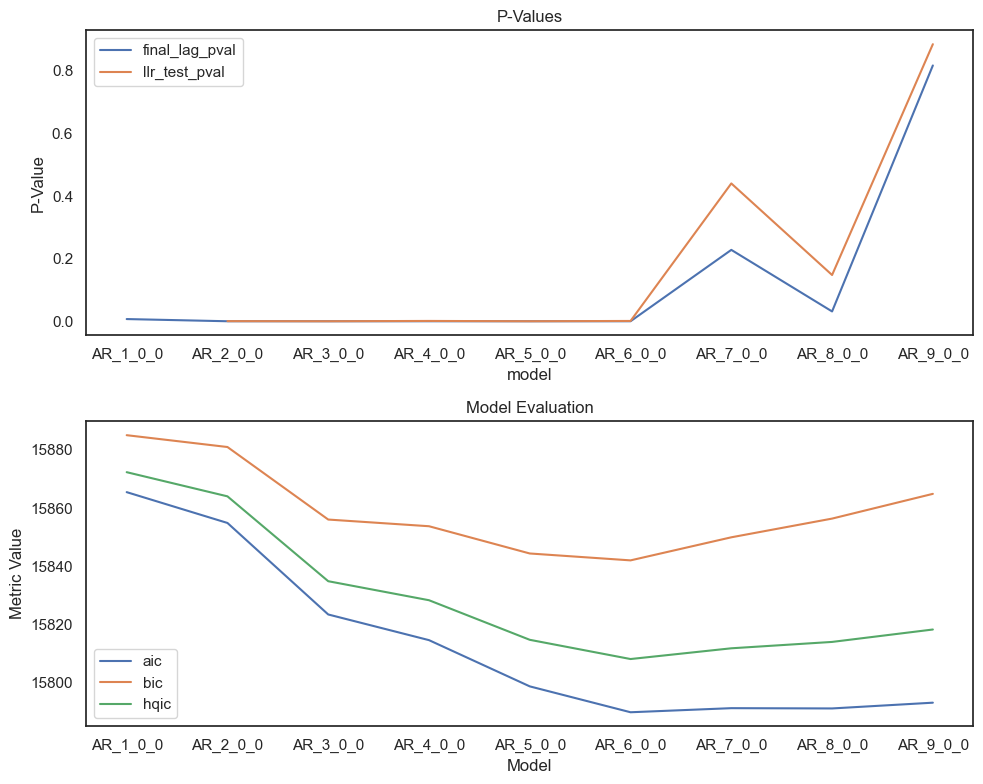

In [14]:
# Create 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot final lag p-value on the first subplot
metrics_returns.evaluation[["final_lag_pval", "llr_test_pval"]].plot(ax=axes[0])
axes[0].set_title("P-Values")
axes[1].set_xlabel("Model")
axes[0].set_ylabel("P-Value")

# Plot AIC, BIC, HQIC on the second subplot
metrics_returns.evaluation[["aic", "bic", "hqic"]].plot(ax=axes[1])
axes[1].set_title("Model Evaluation")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Metric Value")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

- The first model which satisfies the p-values of both the final lag and the LLR Test being non-significant is AR(6).
- Model AR(6) is selected and a LLR Test is performed against AR(1) to confirm significance.

In [16]:
deg_freedom_returns = (
    metrics_returns.evaluation.loc["AR_6_0_0", "ar"]
    - metrics_returns.evaluation.loc["AR_1_0_0", "ar"]
)

metrics_returns.llr_test(
    metrics_returns.evaluation.loc["AR_1_0_0", "llf"],
    metrics_returns.evaluation.loc["AR_6_0_0", "llf"],
    df=deg_freedom_returns,
)

np.float64(5.613201135056091e-17)

## Normalizing Prices

In [ ]:
df["market_val_norm"] = df["market_value"].div(df["market_value"].iloc[0]).mul(100)

In [ ]:
sts.adfuller(df["market_val_norm"])

- The ADF t-statistic is less negative than the 5% critical value and the computed p-value is greater than 0.05, which suggests non-stationarity. Therefore, normalisation does not make prices suitable for an AR model.

## Normalized Returns

In [ ]:
df["returns_norm"] = df["returns"].div(df["returns"].iloc[0]).mul(100)

In [ ]:
sts.adfuller(df["returns_norm"])

- The ADF t-statistic is much more negative than the 5% critical value. The computed p-value is significant. This suggests stationarity. Normalised returns therefore remain suitable for an AR model.

## AR(1) for Normalised Returns

In [ ]:
model_returns_norm = ARIMA(df["returns_norm"], order=(1, 0, 0))
result_returns_norm = model_returns_norm.fit()
result_returns_norm.summary()

- The const values will be different for the returns and normalised returns, but the ar.L1 is the same.

## Higher Lag AR Models for Normalised Returns

In [ ]:
model_generator_returns_norm = ModelGenerator(data=df["returns_norm"])
max_lags = 9
param_grid = [{"order": (p, 0, 0)} for p in range(1, max_lags + 1)]
model_generator_returns_norm.generate_models(
    model_function=ARIMA, model_name_prefix="AR", param_grid=param_grid
)

model_generator_returns_norm.summarise_results()

#### Create a dataframe to tabulate measures of interest

In [ ]:
metrics_returns_norm = MetricsGenerator(models=model_generator_returns_norm.models)
metrics_returns_norm.generate_metrics_table()
metrics_returns_norm.evaluation

- The llf gradually becomes less negative, with slowing down AR_6 onwards.
- The AIC, BIC and HQIC decrease till AR_6 and then start to increase.

In [ ]:
# Find models where both the final lag and the LLR Test p-values fail to reach significance.
metrics_returns_norm.evaluation.query(
    "final_lag_pval >= 0.05 and llr_test_pval >= 0.05"
)

In [ ]:
# Create 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot final lag p-value on the first subplot
metrics_returns_norm.evaluation[["final_lag_pval", "llr_test_pval"]].plot(ax=axes[0])
axes[0].set_title("P-Values")
axes[1].set_xlabel("Model")
axes[0].set_ylabel("P-Value")

# Plot AIC, BIC, HQIC on the second subplot
metrics_returns_norm.evaluation[["aic", "bic", "hqic"]].plot(ax=axes[1])
axes[1].set_title("Model Evaluation")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Metric Value")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

- The first model which satisfies the p-values of both the final lag and the LLR Test being non-significant is AR(6).
- Model AR(6) is selected and a LLR Test is performed against AR(1) to confirm significance.

In [ ]:
# Calculate degrees of freedom from the maximum lags of each model
deg_freedom_returns_norm = (
    metrics_returns_norm.evaluation.loc["AR_6", "ar"]
    - metrics_returns_norm.evaluation.loc["AR_1", "ar"]
)

metrics_returns_norm.llr_test(
    metrics_returns_norm.evaluation.loc["AR_1", "llf"],
    metrics_returns_norm.evaluation.loc["AR_6", "llf"],
    df=deg_freedom_returns_norm,
)

The returned p-value indicates that the AR_6 model is significantly better than the AR_1 model.

## Analysing the Residuals

In [ ]:
# Get residuals from the AR_6 model result
df["residuals_returns"] = model_generator_returns.get_model("AR_6")[1].resid

In [ ]:
df["residuals_returns"].mean()

In [ ]:
df["residuals_returns"].var()

In [ ]:
df["residuals_returns"].plot.box()

- The mean is close to 0 and the variance is low, which suggests that the model performs well.
- The mean close to 0 resembles that of white noise data.

In [ ]:
# ADF Test
sts.adfuller(df["residuals_returns"])

- The **ADF** t-statistic is much more negative than the the 5% critical value and the p-value is 0, both of which suggest stationarity.

In [ ]:
# Plot the ACF for residuals
sgt.plot_acf(df["residuals_returns"], zero=False, lags=40, auto_ylims=True)
plt.title("ACF: FTSE Returns Residuals", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

The majority of residuals are not significantly different from 0, which fits the characteristics of white noise. However, 7 values are significantly different from 0, which indicate that there might be a better predictor.

In [ ]:
# Plot the residual time series.
df["residuals_returns"].plot(figsize=(20, 5))
plt.show()

- As with price residuals, the returns residuals are mostly low and the residuals time series does not indicate an obvious pattern, so the choice of model seems correct.
- The spike around 2008 coincides with the start of The Great Recession